In [1]:
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import gutenberg as gb
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten
from nltk import word_tokenize, sent_tokenize 
import pandas as pd
import lux

古腾堡语料库 NLTK包含古腾堡项目（Project Gutenberg）电子文档的一小部分文本。 该项目大约有25000（现在是36000）本免费电子书。 我们通过平均句子长度和平均词种数（词语丰富度）这两个特征，来看不同作者的写作风格。

NLTK的古腾堡语料库收集的都是不同作家的书

In [2]:
#nltk.download('gutenberg')
#nltk.download('punkt')
#nltk.download('movie_reviews')#电影评论
#nltk.download('webtext') #网络和聊天文本
from nltk.corpus import gutenberg
from nltk.corpus import webtext
from nltk.corpus import movie_reviews
#print(gutenberg.fileids())
send_table = [] # 得到text的二维str数组
text_string = '' # text纯string表示
p = ''',.";:'?()-=+/?()*&^%#;[]!`'''
data_source = gutenberg
for text_id in data_source.fileids():
    print(text_id)
    unit = data_source.sents(text_id)
    for s in unit:
        sent = []
        for word in s:
            if len(word)==1 and word in p:
                continue #在此增加if条件可以去除停用词等
            word = word.lower()
            sent.append(word)
            text_string+=word+' '
        send_table.append(sent)

austen-emma.txt
austen-persuasion.txt
austen-sense.txt
bible-kjv.txt
blake-poems.txt
bryant-stories.txt
burgess-busterbrown.txt
carroll-alice.txt
chesterton-ball.txt
chesterton-brown.txt
chesterton-thursday.txt
edgeworth-parents.txt
melville-moby_dick.txt
milton-paradise.txt
shakespeare-caesar.txt
shakespeare-hamlet.txt
shakespeare-macbeth.txt
whitman-leaves.txt


In [ ]:
#test
send_table = []
sent1 = ['i', 'am', 'sam']
sent2 = ['sam' ,'i', 'am']
sent3 = ['i', 'do', 'not', 'like', 'green', 'eggs', 'and', 'ham']
send_table.append(sent1)
send_table.append(sent2)
send_table.append(sent3)
text_string=''
for s in send_table:
    for word in s:
        word = word.lower()
        text_string+=word+' '

In [ ]:
word_list =[n for a in send_table for n in a]
word_set=set(word_list)

In [3]:
# 对text_string进行词频统计
word_list = []
cnt_list = []
text_tokenized = nltk.word_tokenize(text_string)
#print(text_tokenized)   
from nltk import FreqDist
fdist = FreqDist(text_tokenized)
print(fdist)
for a,b in fdist.items():
    word_list.append(str(a))
    cnt_list.append(b)
dic = {
    'word':word_list,
    'cnt':cnt_list
}
info_table = pd.DataFrame(dic)
info_table.head(10)

<FreqDist with 42127 samples and 2250059 outcomes>


Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [ ]:
info_table.to_csv('./temp.csv')
df = pd.read_csv('./temp.csv')
from lux.vis.Vis import Vis
intent= ['word','cnt']
vis = Vis(intent,df)
vis
print(vis.to_matplotlib())

In [4]:
# Preprocess the tokenized text for 3-grams language modelling
# send_table: list[list(str)]
from nltk.lm.preprocessing import padded_everygram_pipeline
n = 3
train_data, padded_sents = padded_everygram_pipeline(n, send_table)

In [5]:
# 使用nltk 的ngram模型
from nltk.lm import MLE
model = MLE(n) # Lets train a 3-grams model, previously we set n=3

In [6]:
model.fit(train_data, padded_sents)
print(model.vocab)

<Vocabulary with cutoff=1 unk_label='<UNK>' and 42301 items>


In [ ]:
model.score('am',['i'])

In [ ]:
model.logscore('cookie',['<s>'])

In [ ]:
# 2-gram
word2sum = {}
word_set = set()
for sent in send_table:
    w1='<s>'
    for word in sent:
        log_prob = -model.logscore(word,[w1])
        #print(word+' :',end='')
        #print(log_prob)
        if word in word2sum:
            word2sum[word] += log_prob
        else:
            word2sum[word] = log_prob
        w1 = word

In [7]:
# 3-gram
word2sum = {}
word_set = set()
for sent in send_table:
    w1=''
    w2=''
    for word in sent:
        if w2 == '':
            log_prob = -model.logscore(word,['<s>'])
        elif w1 == '':
            log_prob = -model.logscore(word,["<s>",w2])
        else:
            log_prob = -model.logscore(word,[w1,w2])
        if word in word2sum:
            word2sum[word] += log_prob
        else:
            word2sum[word] = log_prob
        w1 = w2
        w2 = word

In [8]:
#增加词长、计算信息量
word_count_table = pd.DataFrame()
for n,word in enumerate(info_table['word']):
    # Create a list of just the word we are interested in, we use regular expressions so that part of words do not count
    # e.g. 'ear' would be counted in each appearance of the word 'year'
    word_count = len(word)  
    word_count_table = word_count_table.append(pd.DataFrame({'len':word_count}, index=[n]))
info_table['len'] = word_count_table['len']
info_table.head()
sum_table = pd.DataFrame()
for n,word in enumerate(info_table['word']):
    if word not in word2sum:
        sum_table = sum_table.append(pd.DataFrame({'sum':0}, index=[n]))
        continue
    sum_proc = word2sum[word]
    sum_table = sum_table.append(pd.DataFrame({'sum':sum_proc}, index=[n]))
info_table['sum_neg_log_prob'] = sum_table['sum']
info_table['averge_content'] = (info_table['sum_neg_log_prob']/info_table['cnt'])
info_table.head(30)

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [31]:
info_table.sort_values(by='cnt',ascending='',inplace=True)
info_table = info_table.iloc[:200]
info_table.intent = ['len','averge_content']
info_table.head(100)


/Users/wofeishenling/opt/anaconda3/envs/stopwords/lib/python3.9/site-packages/pandas/core/frame.py:5477: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [ ]:
print (vis.to_matplotlib())

In [32]:
#spearman correlation coefficient
#原始数据
X1= info_table['len']
Y1= info_table['averge_content']
Z1= info_table['cnt']
#s.corr()函数计算
r=X1.corr(Y1,method='spearman')
q=X1.corr(Z1,method='spearman')
print("corelationship of len and averge_content: %f",r)
print("corelationship of len and freq: %f",q)

corelationship of len and averge_content: %f 0.056950661706265955
corelationship of len and freq: %f -0.2760603279989578


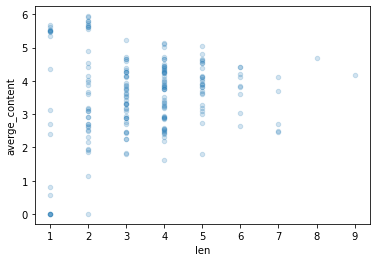

In [33]:
info_table.plot.scatter(x="len", y="averge_content",alpha=0.2)
plt.savefig('./3-gram_gutenberg_top_200.jpg', bbox_inches='tight', dpi=300)
long_word = list(info_table[info_table['len']>10]['word'])

In [35]:
info_table_lenle3 = info_table[info_table['len']<4]
info_table_lenle3[info_table_lenle3['averge_content']>4].head(100)

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [ ]:
info_table.to_csv('./info_csv')
import lux
df = pd.read_csv('./info_csv')
from lux.vis.Vis import Vis
intent = ['averge_content',"len"]
vis = Vis(intent,df)
vis